# Avito Demand Prediction Challenge - Aggregated Features

## Introduction
When selling used goods online, a combination of tiny, nuanced details in a product description can make a big difference in drumming up interest.

Avito, Russia’s largest classified advertisements website, is deeply familiar with this problem. Sellers on their platform sometimes feel frustrated with both too little demand (indicating something is wrong with the product or the product listing) or too much demand (indicating a hot item with a good description was underpriced).

In [their fourth Kaggle competition](https://kaggle.com/c/avito-demand-prediction), Avito is challenging participants to predict demand for an online advertisement based on its full description (title, description, images, etc.), its context (geographically where it was posted, similar ads already posted) and historical demand for similar ads in similar contexts. With this information, Avito can inform sellers on how to best optimize their listing and provide some indication of how much interest they should realistically expect to receive.

The description of the data files from the [data page](https://www.kaggle.com/c/avito-demand-prediction/data):

* train.csv - Train data.
* test.csv - Test data. Same schema as the train data, minus deal_probability.
* train_active.csv - Supplemental data from ads that were displayed during the same period as train.csv. Same schema as the train data, minus deal_probability.
* test_active.csv - Supplemental data from ads that were displayed during the same period as test.csv. Same schema as the train data, minus deal_probability.
* periods_train.csv - Supplemental data showing the dates when the ads from train_active.csv were activated and when they where displayed.
* periods_test.csv - Supplemental data showing the dates when the ads from test_active.csv were activated and when they where displayed. Same schema as periods_train.csv, except that the item ids map to an ad in test_active.csv.
* train_jpg.zip - Images from the ads in train.csv.
* test_jpg.zip - Images from the ads in test.csv.
* sample_submission.csv - A sample submission in the correct format.

## Engineering aggregated features

In this kernel we will take a look at engineering aggregated features. Specifically, we will engineer 3 aggregated features using `train_active.csv`, `test_active.csv`, `periods_test.csv` and `periods_test.csv`. Those features will be:
- `avg_times_up_user` - how often the *average* item of a user has been put up for sale.
- `avg_days_up_user` - the average number of days the average item from a user has been put up for sale.
- `n_user_items` - the number of items a user has put up for sale.

We break this notebook down into 4 steps. 
**Steps:**
- [Step 1](#step1): Read in csv files
- [Step 2](#step2): Visualize the overlap between dataframes
- [Step 3](#step3): Merge dataframes
- [Step 4](#step4): Create new features

First, let's import some libraries.

In [1]:
import pandas as pd
import numpy as np
import gc
import lightgbm as lgb

import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn2_circles
%matplotlib inline

<a id="step1"></a>
## Load csv files

Start with loading the data. To save some memory, we only load `item_id` and `user_id`, as that's all we need for the proposed features.

In [2]:
used_cols = ['item_id', 'user_id']

train = pd.read_csv('./csv/train.csv', usecols=used_cols)
train_active = pd.read_csv('./csv/train_active.csv', usecols=used_cols)
test = pd.read_csv('./csv/test.csv', usecols=used_cols)
test_active = pd.read_csv('./csv/test_active.csv', usecols=used_cols)

train_periods = pd.read_csv('./csv/periods_train.csv', parse_dates=['date_from', 'date_to'])
test_periods = pd.read_csv('./csv/periods_test.csv', parse_dates=['date_from', 'date_to'])

train.head()

,item_id,user_id
0,b912c3c6a6ad,e00f8ff2eaf9
1,2dac0150717d,39aeb48f0017
2,ba83aefab5dc,91e2f88dd6e3
3,02996f1dd2ea,bf5cccea572d
4,7c90be56d2ab,ef50846afc0b


<a id="step2"></a>
## Visualize overlap
It's time for some visualizations. The following venn diagrams show the overlap of the user ID between the relevant dataframes. If this overlap is reasonably large, it might be a good idea to use the aggregated features.

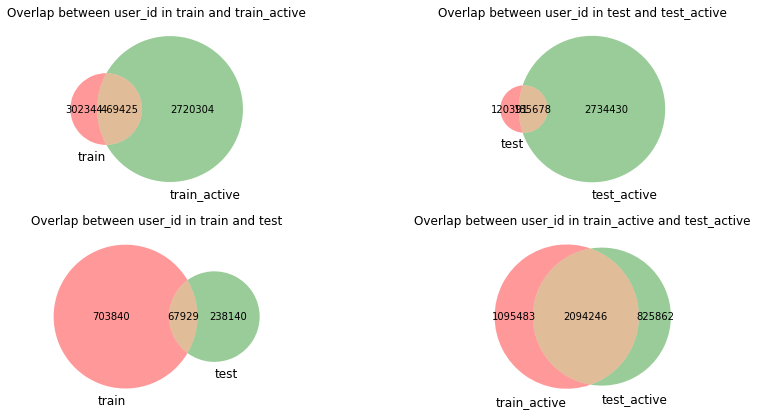

In [3]:
fig, axarr = plt.subplots(2, 2, figsize=(14, 7))

def get_venn(axarr, feature):
    axarr[0, 0].set_title(f'Overlap between {feature} in train and train_active')
    venn2([
        set(train[feature].values), 
        set(train_active[feature].values)
    ], set_labels = ('train', 'train_active'), ax=axarr[0, 0])

    axarr[0, 1].set_title(f'Overlap between {feature} in test and test_active')
    venn2([
        set(test[feature].values), 
        set(test_active[feature].values)
    ], set_labels = ('test', 'test_active'), ax=axarr[0, 1])

    axarr[1, 0].set_title(f'Overlap between {feature} in train and test')
    venn2([
        set(train[feature].values), 
        set(test[feature].values)
    ], set_labels = ('train', 'test'), ax=axarr[1, 0])

    axarr[1, 1].set_title(f'Overlap between {feature} in train_active and test_active')
    venn2([
        set(train_active[feature].values), 
        set(test_active[feature].values)
    ], set_labels = ('train_active', 'test_active'), ax=axarr[1, 1])
    
get_venn(axarr, 'user_id')

We're lucky! There is a huge overlap between the IDs of `train` / `train_active` and `test` / `test_active`. Out of curiosity, we'll also take a look at the overlap of item ID. This should (hopefully) not overlap at all.

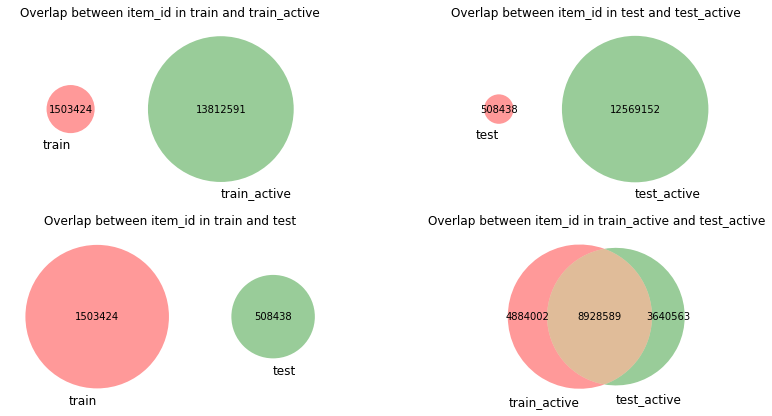

In [4]:
fig, axarr = plt.subplots(2, 2, figsize=(14, 7))

get_venn(axarr, 'item_id')

As suspected, there is no overlap between the dataframes, except for `train_active` and `test_active`. These might be duplicated rows or items that have been put up for sale multiple times. We will have to filter these duplicated IDs for our engineered features.

<a id="step3"></a>
## Merge dataframes

We will now merge the data into one dataframe and, as mentioned, drop the duplicate item IDs. At this point we can also delete `train_active` and `test_active` to free up some memory.

In [5]:
all_samples = pd.concat([
    train,
    train_active,
    test,
    test_active
]).reset_index(drop=True)
all_samples.drop_duplicates(['item_id'], inplace=True)

del train_active
del test_active
gc.collect()

5760

We will also concatenate the train and test period data to one dataframe for easier processing.

In [6]:
all_periods = pd.concat([
    train_periods,
    test_periods
])

del train_periods
del test_periods
gc.collect()

all_periods.head()

,item_id,activation_date,date_from,date_to
0,8f5caef7afb0,2017-02-14,2017-03-15,2017-03-16
1,66218ff526d1,2017-02-16,2017-03-15,2017-03-18
2,b237d9539b21,2017-03-01,2017-03-15,2017-03-28
3,80bf58082ad3,2017-03-19,2017-03-19,2017-03-28
4,67a9944a7373,2017-03-14,2017-03-15,2017-03-28


<a id="step4"></a>
## Create new features

Now the interesting part begins! For our feature `avg_days_up_user`, we first have to calculate the number of days every item has been put up. This can easily be done with pandas's `dt` API.

In [7]:
all_periods['days_up'] = all_periods['date_to'].dt.dayofyear - all_periods['date_from'].dt.dayofyear

Because we want the total number of days an item has been put up for sale, we will group by `item_id` and sum the `days_up` column. We will also count the number of items in an item ID group for our second feature, `avg_times_up_user`.

In [8]:
gp = all_periods.groupby(['item_id'])[['days_up']]

gp_df = pd.DataFrame()
gp_df['days_up_sum'] = gp.sum()['days_up']
gp_df['times_put_up'] = gp.count()['days_up']
gp_df.reset_index(inplace=True)
gp_df.rename(index=str, columns={'index': 'item_id'})

gp_df.head()

,item_id,days_up_sum,times_put_up
0,00000077ff21,13,1
1,000002c54018,6,1
2,000005570503,1,1
3,0000060018e6,6,1
4,000006497719,19,2


At this point, we have 2 scalars associated with every `item_id` appearing in train and test periods. We can now savely drop the duplicate item IDs in the `all_periods` dataframe and merge the features back into `all_periods`.

In [9]:
all_periods.drop_duplicates(['item_id'], inplace=True)
all_periods = all_periods.merge(gp_df, on='item_id', how='left')
all_periods.head()

,item_id,activation_date,date_from,date_to,days_up,days_up_sum,times_put_up
0,8f5caef7afb0,2017-02-14,2017-03-15,2017-03-16,1,17,4
1,66218ff526d1,2017-02-16,2017-03-15,2017-03-18,3,18,3
2,b237d9539b21,2017-03-01,2017-03-15,2017-03-28,13,19,2
3,80bf58082ad3,2017-03-19,2017-03-19,2017-03-28,9,17,4
4,67a9944a7373,2017-03-14,2017-03-15,2017-03-28,13,18,3


In [10]:
del gp
del gp_df
gc.collect()

114

We have an interesting but kind of useless feature now. As seen in the second venn diagram, there is no overlap at all between `train_active`/`train_periods` and `train` concerning *item* IDs. For the feature to become useful, we somehow have to associate an item ID with a user ID.

So the next step is to merge `all_samples` into `all_periods`. This will get us a user ID for every item ID in the periods dataframes. Now there is an overlap!

In [11]:
all_periods = all_periods.merge(all_samples, on='item_id', how='left')
all_periods.head()

,item_id,activation_date,date_from,date_to,days_up,days_up_sum,times_put_up,user_id
0,8f5caef7afb0,2017-02-14,2017-03-15,2017-03-16,1,17,4,e292cce69842
1,66218ff526d1,2017-02-16,2017-03-15,2017-03-18,3,18,3,a326c04a24ec
2,b237d9539b21,2017-03-01,2017-03-15,2017-03-28,13,19,2,06d275498a56
3,80bf58082ad3,2017-03-19,2017-03-19,2017-03-28,9,17,4,831c8c4a622c
4,67a9944a7373,2017-03-14,2017-03-15,2017-03-28,13,18,3,248102e50d79


The next problem is that there are multiple features for a user if that user has put up more than one item that appears in `train_active` / `test_active`. We will have to somehow reduce this to one feature.

Here they are averaged, but we can try something else like median or modus too.

In [12]:
gp = all_periods.groupby(['user_id'])[['days_up_sum', 'times_put_up']].mean().reset_index() \
    .rename(index=str, columns={
        'days_up_sum': 'avg_days_up_user',
        'times_put_up': 'avg_times_up_user'
    })
gp.head()

,user_id,avg_days_up_user,avg_times_up_user
0,00000077ff21,12.5,2.00
1,000006497719,19.0,2.00
2,00000b4d72f6,3.0,1.00
3,00000d642d7e,13.0,1.00
4,0000126b80a4,12.0,1.75


For our last feature, `n_user_items`, we just group by user ID and count the number of items. We have to be careful to use `all_samples` instead of `all_periods` here because the latter does not contain the `train.csv` and `test.csv` samples.

In [13]:
n_user_items = all_samples.groupby(['user_id'])[['item_id']].count().reset_index() \
    .rename(index=str, columns={
        'item_id': 'n_user_items'
    })
gp = gp.merge(n_user_items, on='user_id', how='outer')

gp.head()

,user_id,avg_days_up_user,avg_times_up_user,n_user_items
0,00000077ff21,12.5,2.00,2
1,000006497719,19.0,2.00,1
2,00000b4d72f6,3.0,1.00,1
3,00000d642d7e,13.0,1.00,2
4,0000126b80a4,12.0,1.75,8


We'll save the features to a CSV so we don't have to run the entire code again if we want to use them our model.

In [14]:
gp.to_csv('aggregated_features.csv', index=False)

In [15]:
del all_samples
del all_periods
del train
del test

gc.collect()

126

# Next steps

We will use these new features to train our lightGBM model.